# Gokigen Naname

- Can be found at: [Link](https://www.janko.at/Raetsel/Gokigen-Naname/index.htm)

RULES:

1. Draw exactly one diagonal line in each cell of the grid.
2. A number in a grid dot indicates how many diagonal lines end in this grid dot.
3. **The diagonal lines must not form a closed loop.**

Algorithm:

1. Add model with Constr 1~2;
2. For any current solution, iterate all connected components and check if they form a loop. If so, use Lazy Constraint to remove these loops from the model.


In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import gurobipy as grb


In [2]:
# 并查集（Union-Find）用于检测环
class UnionFind:
    def __init__(self, nodes):
        self.parent = {node: node for node in nodes}

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        if root_x == root_y:
            return False  # 出现环
        self.parent[root_y] = root_x
        return True

# 提取连通分量
def find_connected_components(edges):
    graph = defaultdict(list)
    for u, v in edges:
        graph[u].append(v)
        graph[v].append(u)

    visited = set()
    components = []

    def dfs(node, current_component):
        visited.add(node)
        current_component.add(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor, current_component)

    for node in graph:
        if node not in visited:
            current_component = set()
            dfs(node, current_component)
            components.append(current_component)

    grouped_edges = []
    for component in components:
        component_edges = []
        for u, v in edges:
            if u in component and v in component:
                component_edges.append((u, v))
        grouped_edges.append(component_edges)

    return grouped_edges

# 判断每个连通分量是否成环
def check_cycles_in_components(edges):
    components = find_connected_components(edges)
    results = []

    for component_edges in components:
        # 获取该连通分量的所有节点
        nodes = set()
        for u, v in component_edges:
            nodes.add(u)
            nodes.add(v)

        uf = UnionFind(nodes)
        has_cycle = False
        for u, v in component_edges:
            if not uf.union(u, v):
                has_cycle = True
                break  # 已发现环，不需继续检测

        results.append({
            'component_edges': component_edges,
            'has_cycle': has_cycle
        })

    return results

if __name__ == "__main__":
# 示例输入：无向边列表
    edges = [(0, 1), (1, 2), (2, 0),  # 构成一个三角形（有环）
            (3, 4),                  # 单独的一条边（无环）
            (5, 6), (6, 7), (6, 8)]  # 构成一个三角形（有环）
    # 执行检测
    results = check_cycles_in_components(edges)
    # 输出结果
    for i, res in enumerate(results):
        # print(f"第 {i + 1} 个连通分量的边: {res['component_edges']}")
        print("是否构成环:", "是" if res['has_cycle'] else "否")
        print("-" * 30)


是否构成环: 是
------------------------------
是否构成环: 否
------------------------------
是否构成环: 否
------------------------------


In [3]:
def readGrid(path):
    with open(f"../assets/data/GokigenNaname/problems/{path}.txt") as f:
        num = f.readline()
        m, n = num.split(" ")[0], num.split(" ")[1]
        grid = f.readlines()
        res = [g.strip().split(" ") for g in grid]
        for idx, g in enumerate(res):
            res[idx] = list(map(str, g))
        return int(m), int(n), res

def visualize_Gokigen(m , n, arcs):
    """Visualize the whole graph ... 

    Args:
        m (_type_): _description_
        n (_type_): _description_
        arcs (_type_): _description_

    Returns:
        _type_: _description_
    """
    # 定义网格大小
    # 创建网格
    fig, ax = plt.subplots()

    # 设置网格线
    ax.set_xticks(range(n + 2))
    ax.set_yticks(range(m + 2))
    ax.grid(True)

    # 设置网格的边界
    ax.set_xlim(0,  n )
    ax.set_ylim(0,  m )

    # 设置网格的标签
    ax.set_xticklabels(range(n + 2))
    ax.set_yticklabels(range(m + 2))
    ax.set_aspect('equal')  # 设置坐标轴比例为相等
    # 绘制边
    for arc in arcs:
        start, end = arc
        # 计算起点和终点的坐标
        start_x = start % (n + 1)
        start_y = start // (n + 1)
        end_x = end % (m + 1)
        end_y = end // (m + 1)
        
        # 绘制边
        ax.plot([start_x, end_x], [start_y, end_y], marker='o', color='r')

    # 显示图形
    plt.gca().invert_yaxis()  # 反转y轴，使得(0,0)在左上角
    plt.show()

def GokigenNanameSolver(m, n, grid):
    x = dict()
    GokigenNaname = grb.Model("GokigenNaname")
    
    for i in range(m):
        for j in range(n):
            if i + 1 < m and j - 1 >= 0: 
                x[i * n + j, (i + 1) * n + j - 1] = GokigenNaname.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[ {i * n + j}, {(i + 1) * n + j - 1}]"
                )
            if i + 1 < m and j + 1 < n:
                x[i * n + j, (i + 1) * n + j + 1] = GokigenNaname.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[ {i * n + j}, {(i + 1) * n + j + 1}]"
                )
    for i in range(m):
        for j in range(n):
            if grid[i][j] in "1234567890":
                # add constrs here
                temp_list = []
                if i - 1 >= 0 and j - 1 >= 0:
                    temp_list.append(x[(i - 1) * n + j - 1, i * n + j])
                if i - 1 >= 0 and j + 1 < n:
                    temp_list.append(x[(i - 1) * n + j + 1, i * n + j])
                if i + 1 < m and j + 1 < n:
                    temp_list.append(x[i * n + j, (i + 1) * n + j + 1])
                if i + 1 < m and j - 1 >= 0:
                    temp_list.append(x[i * n + j, (i + 1) * n + j - 1])
                if len(temp_list) > 0:
                    GokigenNaname.addConstr(grb.quicksum(temp_list) == int(grid[i][j]), name = f"Num_{i}_{j}")

    for i in range(m - 1):
        for j in range(n - 1):
            GokigenNaname.addConstr(grb.quicksum([x[i * m + j, (i + 1) * m + j + 1], x[i * m + j + 1, (i + 1) * m + j]]) == 1, name = f"NoConflict_{i}_{j}")
    

    GokigenNaname.modelSense = grb.GRB.MINIMIZE
    GokigenNaname.Params.lazyConstraints = 1
    GokigenNaname.update()
    GokigenNaname._x = x
    
    def subloopelim(model, where):
        if (where == grb.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            cur_arcs = []
            for (i, j) in x.keys():
                if x_sol[i, j] > 1e-1:
                    cur_arcs.append((i, j))
            temp_check = check_cycles_in_components(cur_arcs)
            
            for cnt_component in temp_check:
                if cnt_component['has_cycle']:
                    # print(f"Add elim Routes: {cnt_component['component_edges']}")
                    model.cbLazy(
                        grb.quicksum(x[i, j] for (i, j) in cnt_component['component_edges']) \
                         <= len(cnt_component['component_edges']) - 1)

    GokigenNaname._x = x
    GokigenNaname.optimize(subloopelim)
    ofv = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (GokigenNaname.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = GokigenNaname.getObjective().getValue()
        print(ofv)
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        gap = 0
        lb = ofv
        ub = ofv
        runtime = GokigenNaname.Runtime
    elif (GokigenNaname.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = GokigenNaname.MIPGap
        lb = GokigenNaname.ObjBoundC
        ub = GokigenNaname.ObjVal
        runtime = GokigenNaname.Runtime
    
    return arcs


Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 150 rows, 200 columns and 364 nonzeros
Model fingerprint: 0x45cc583b
Variable types: 0 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 143 rows and 173 columns
Presolve time: 0.00s
Presolved: 7 rows, 27 columns, 26 nonzeros
Variable types: 0 continuous, 27 integer (27 binary)

Root relaxation: objective 1.000000e+02, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  100.00000    0    5          -  100.00000      -   

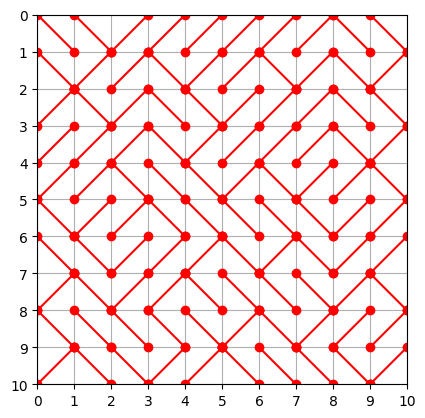

In [5]:
if __name__ == "__main__":
    m, n, grid = readGrid("762_11x11")
    arcs = GokigenNanameSolver(m, n, grid)
    visualize_Gokigen(m - 1, n - 1, arcs)

1 2
3 4
